# Disgregacion de grupos

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def calcular_ratios_por_estacion(estacion, carpeta="listos"):
    """
    Calcula los ratios Rotíferos / Copépodos / Cladóceros
    para cada laguna dentro de una estación climática.
    """
    ruta = os.path.join(carpeta, f"{estacion}.csv")
    df = pd.read_csv(ruta)

    grupo_cols = ["Rotiferos", "Copepodos", "Cladoceros"]
    lagunas = [c for c in df.select_dtypes(include=[np.number]).columns if c not in grupo_cols]

    resultados = []
    for laguna in lagunas:
        total = df[laguna].sum()
        if total == 0:
            rot = cop = cla = np.nan
        else:
            rot = df.loc[df["Rotiferos"] == 1, laguna].sum() / total
            cop = df.loc[df["Copepodos"] == 1, laguna].sum() / total
            cla = df.loc[df["Cladoceros"] == 1, laguna].sum() / total

        resultados.append({
            "Estacion": estacion,
            "Laguna": laguna,
            "Rotiferos": rot,
            "Copepodos": cop,
            "Cladoceros": cla
        })

    return pd.DataFrame(resultados)


def resumen_ratios_general(carpeta="listos"):
    """
    Itera sobre las estaciones, calcula ratios y promedia por laguna base (L1,C,L2).
    Devuelve un DataFrame con ratios promedio por laguna y estación.
    """
    estaciones = ["invierno", "verano", "otoño", "primavera"]
    df_final = pd.DataFrame()

    for e in estaciones:
        df_ratios = calcular_ratios_por_estacion(e, carpeta)

        # Crear columna 'Laguna_base' (nombre antes del espacio)
        df_ratios["Laguna_base"] = df_ratios["Laguna"].str.split().str[0]

        # Promedio de los tres puntos (L1, C, L2)
        df_mean = (
            df_ratios
            .groupby(["Estacion", "Laguna_base"], as_index=False)
            [["Rotiferos", "Copepodos", "Cladoceros"]]
            .mean()
        )

        df_final = pd.concat([df_final, df_mean], ignore_index=True)

    return df_final


In [2]:
# -----------------------------
# Ejecutar el flujo completo
# -----------------------------
df_ratios_final = resumen_ratios_general("listos")

# Guardar resultado
df_ratios_final.to_csv("ratios_zooplancton_por_laguna_y_estacion.csv", index=False)

print("✅ Archivo generado: ratios_zooplancton_por_laguna_y_estacion.csv")
df_ratios_final.head(5)

✅ Archivo generado: ratios_zooplancton_por_laguna_y_estacion.csv


,Estacion,Laguna_base,Rotiferos,Copepodos,Cladoceros
0,invierno,Crespo,1.000000,0.000000,0.000000
1,invierno,Espinillo,0.824000,0.016393,0.159606
2,invierno,Gazano,0.997339,0.002661,0.000000
3,invierno,Hernandez,0.904063,0.077374,0.018563
4,invierno,Inta,0.581541,0.369375,0.049084


In [3]:
hfi = {"Inta":6.83,
       "Hernandez":3.11,
       "Viale":5.09,
       "Crespo":7.32,
       "Espinillo": 4.42,
       "Termas":5.69,
       "Gazano": 6.93
       }

df_ratios_final["HFI"] = df_ratios_final["Laguna_base"].map(hfi)
df =df_ratios_final

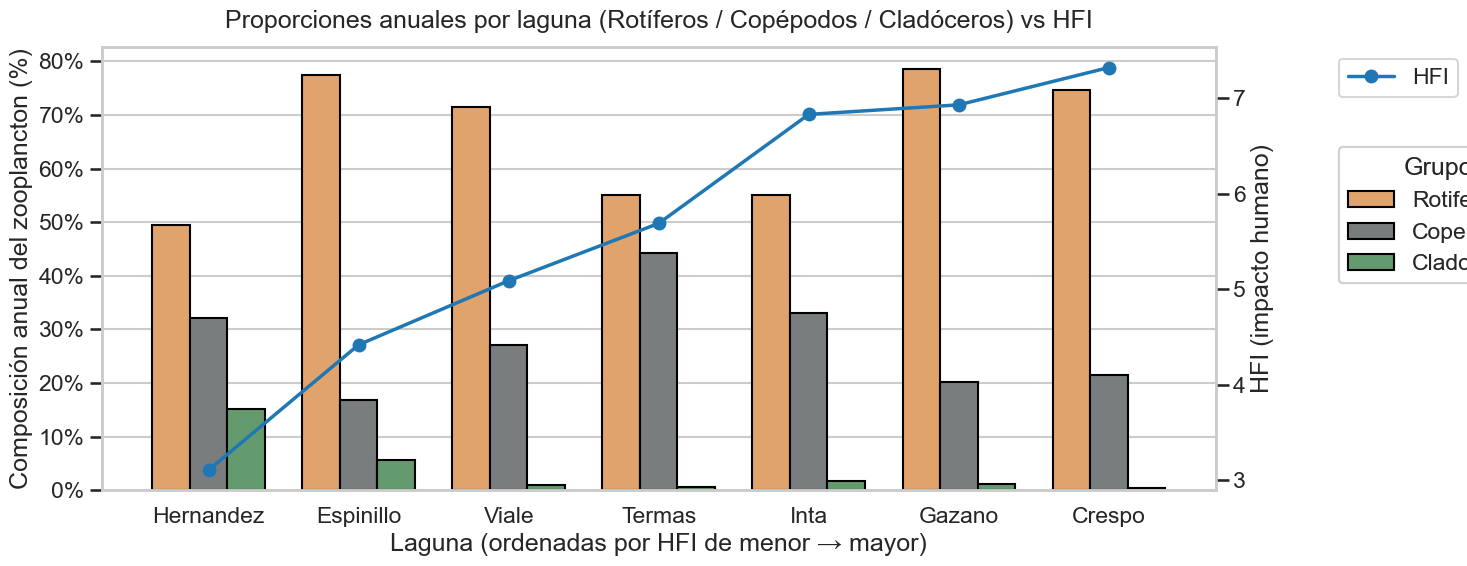

In [4]:
annual = (
    df.groupby("Laguna_base", as_index=False)
      .agg({
          "Rotiferos": "mean",
          "Copepodos": "mean",
          "Cladoceros": "mean",
          "HFI": "mean"   # si HFI es anual fijo, da igual mean/first
      })
)

# Orden por HFI
annual = annual.sort_values("HFI", ascending=True).reset_index(drop=True)

# Long para barras (triadas)
annual_long = annual.melt(
    id_vars=["Laguna_base", "HFI"],
    value_vars=["Rotiferos", "Copepodos", "Cladoceros"],
    var_name="Grupo",
    value_name="Proporcion"
)

# --- 2) Gráfico: barras agrupadas + HFI en eje secundario ---
sns.set(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(18,6))

hue_order = ["Rotiferos", "Copepodos", "Cladoceros"]
palette   = {"Rotiferos":"#f4a259", "Copepodos":"#7a7d7d", "Cladoceros":"#5aa469"}

# Barras (triadas por laguna)
bars = sns.barplot(
    data=annual_long,
    x="Laguna_base", y="Proporcion", hue="Grupo",
    hue_order=hue_order, palette=palette,
    errorbar=None, edgecolor="black", width=0.75, ax=ax
)

# Formato porcentual para proporciones
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{100*v:.0f}%"))
ax.set_ylabel("Composición anual del zooplancton (%)")
ax.set_xlabel("Laguna (ordenadas por HFI de menor → mayor)")
plt.setp(ax.get_xticklabels(), rotation=0)

# Eje secundario para HFI (línea + puntos)
ax2 = ax.twinx()
xpos = np.arange(len(annual))  # posiciones de categorías
ax2.plot(xpos, annual["HFI"], marker="o", linewidth=2.5, color="#1f77b4", label="HFI")
ax2.set_ylabel("HFI (impacto humano)")
ax2.grid(False)

# Alinear ticks del eje x con las categorías
ax.set_xticks(xpos)
ax.set_xticklabels(annual["Laguna_base"])

# Leyendas: combinamos barras (hue) + línea HFI
handles1, labels1 = ax.get_legend_handles_labels()
leg2 = ax2.legend([leg for leg in ax2.lines], ["HFI"], loc="upper left", bbox_to_anchor=(1.10, 1))
leg1 = ax.legend(handles1, labels1, title="Grupo", loc="upper left", bbox_to_anchor=(1.10, 0.8))
ax.add_artist(leg1)  # asegurar que quede la de barras

plt.title("Proporciones anuales por laguna (Rotíferos / Copépodos / Cladóceros) vs HFI", pad=14)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # deja más espacio a la derecha
plt.savefig("ratios.png")
plt.show()


In [9]:
df

,Estacion,Laguna_base,Rotiferos,Copepodos,Cladoceros,HFI
0,invierno,Crespo,1.000000,0.000000,0.000000,7.32
1,invierno,Espinillo,0.824000,0.016393,0.159606,4.42
2,invierno,Gazano,0.997339,0.002661,0.000000,6.93
3,invierno,Hernandez,0.904063,0.077374,0.018563,3.11
4,invierno,Inta,0.581541,0.369375,0.049084,6.83
5,invierno,Termas,0.474805,0.513290,0.011905,5.69
6,invierno,Viale,0.942386,0.022443,0.035171,5.09
7,verano,Crespo,0.493943,0.499032,0.007025,7.32
8,verano,Espinillo,0.826668,0.166006,0.007326,4.42
9,verano,Gazano,0.926575,0.073425,0.000000,6.93


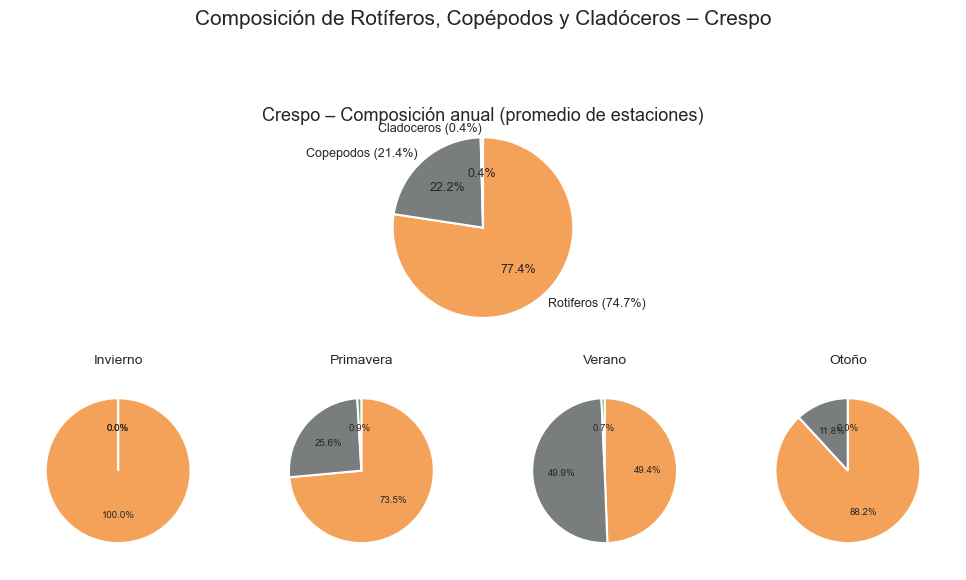

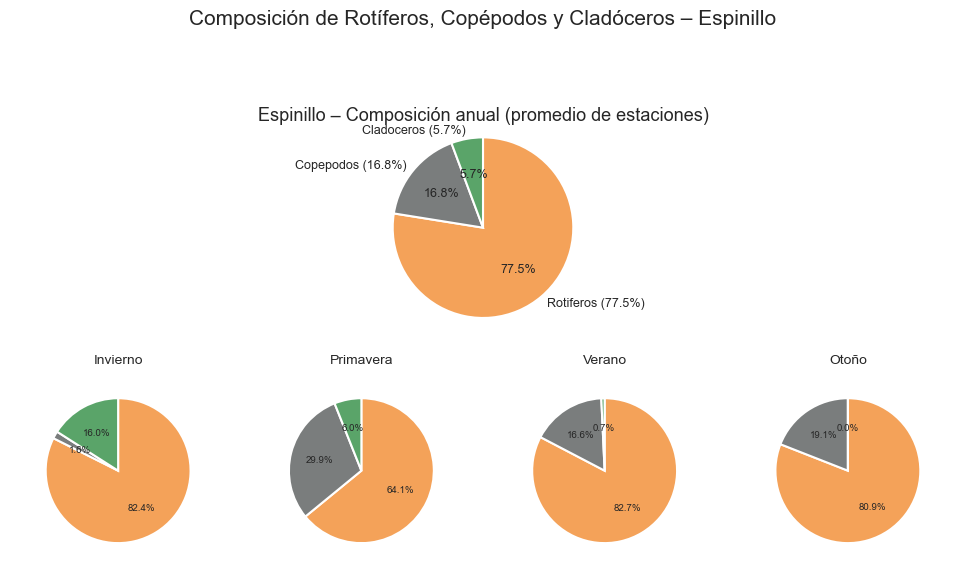

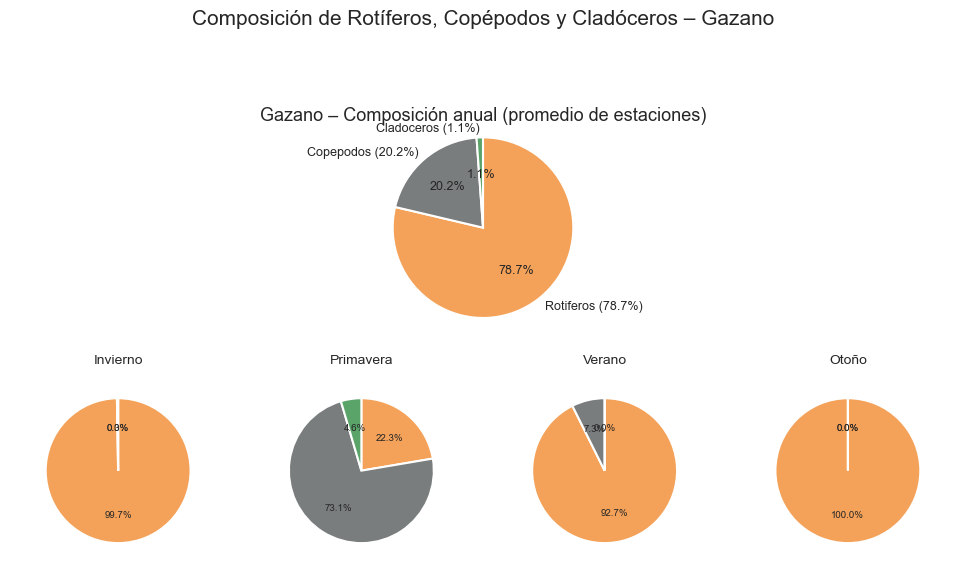

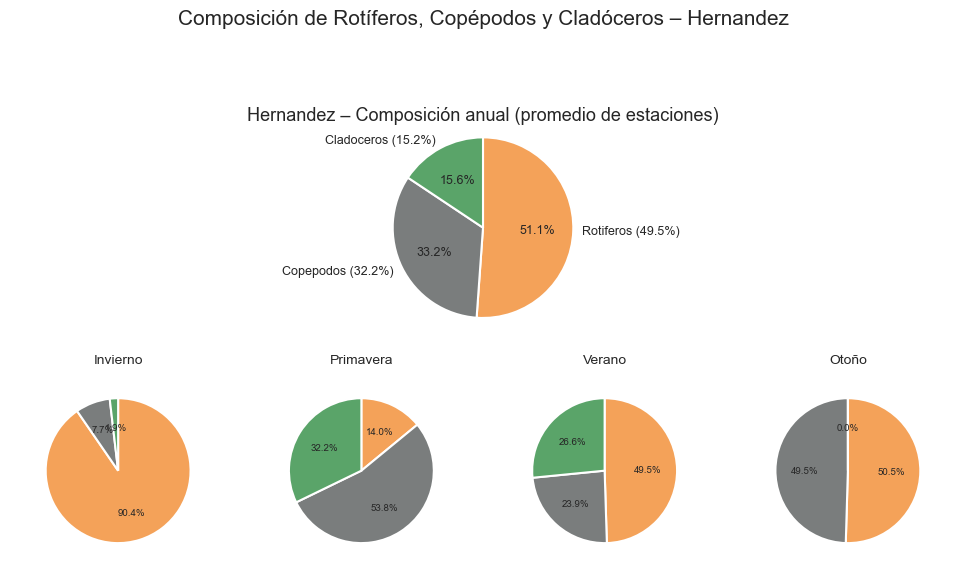

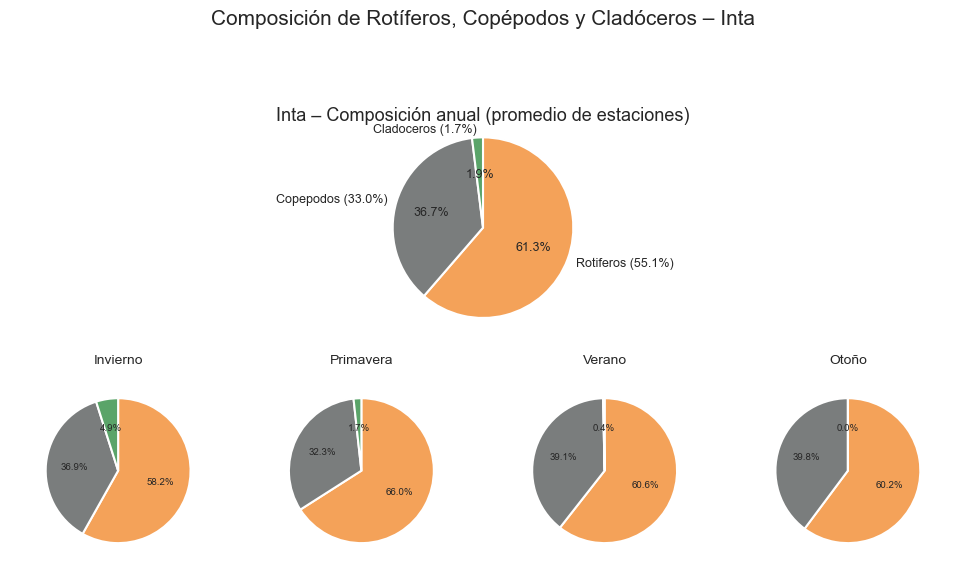

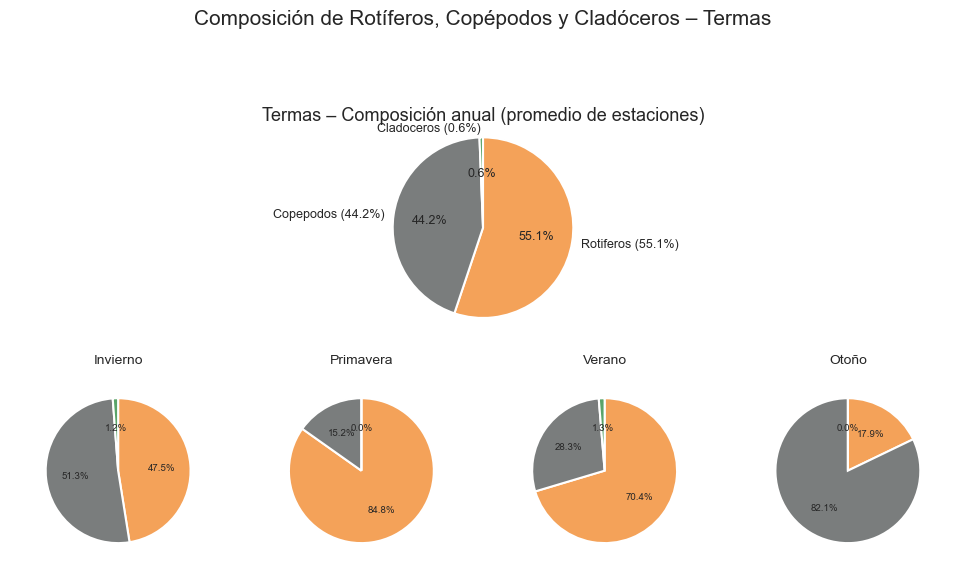

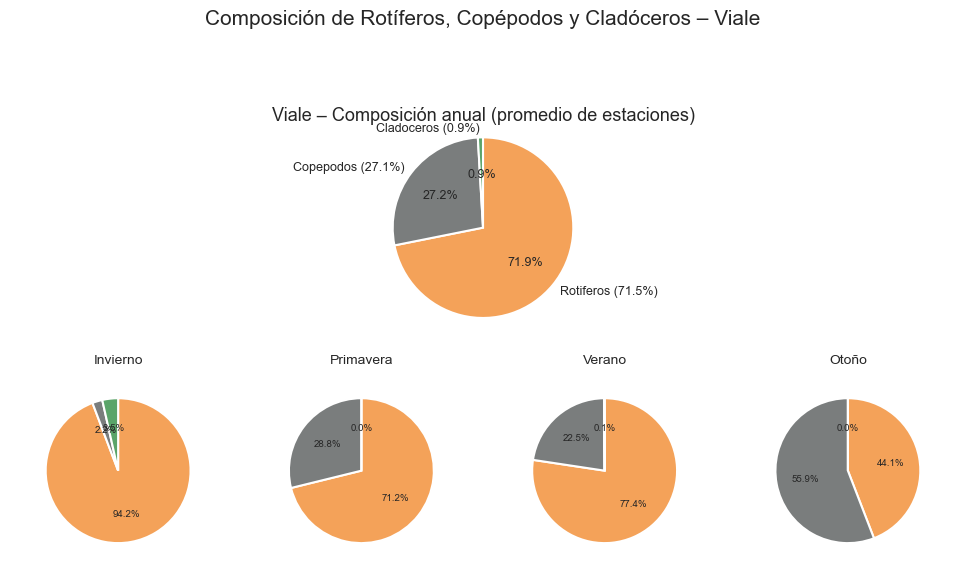

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Orden de estaciones
orden_estaciones = ["invierno", "primavera", "verano", "otoño"]
df["Estacion"] = pd.Categorical(df["Estacion"], categories=orden_estaciones, ordered=True)

palette = {
    "Rotiferos": "#f4a259",
    "Copepodos": "#7a7d7d",
    "Cladoceros": "#5aa469"
}
grupos = ["Rotiferos", "Copepodos", "Cladoceros"]

lagunas = sorted(df["Laguna_base"].unique())

for lag in lagunas:
    sub = df[df["Laguna_base"] == lag].copy()

    # --- 1) Proporciones ANUALES (promedio de proporciones de las 4 estaciones)
    annual_vals = sub[grupos].mean()

    # Si todo es cero o NaN, evitamos explotar
    if np.isclose(annual_vals.fillna(0).sum(), 0):
        print(f"⚠️ {lag}: sin datos válidos para el promedio anual, se salta figura.")
        continue

    annual_labels = [f"{g} ({annual_vals[g]*100:.1f}%)" for g in grupos]

    # --- Crear figura para ESTA laguna ---
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 4, height_ratios=[2, 2])

    # Pie anual (fila 0, ocupa todas las columnas)
    ax_annual = fig.add_subplot(gs[0, :])
    pie_out = ax_annual.pie(
        annual_vals.values,
        labels=annual_labels,
        colors=[palette[g] for g in grupos],
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        textprops={"fontsize": 9}
    )
    # Matplotlib >=3: devuelve (wedges, texts, autotexts)
    wedges, texts, autotexts = pie_out

    ax_annual.set_title(f"{lag} – Composición anual (promedio de estaciones)", fontsize=13)
    ax_annual.axis('equal')

    # --- 2) Pies por estación en la fila inferior ---
    axes_season = [fig.add_subplot(gs[1, i]) for i in range(4)]

    for ax, est in zip(axes_season, orden_estaciones):
        sub_est = sub[sub["Estacion"] == est]

        if sub_est.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center", fontsize=8)
            ax.axis('off')
            continue

        vals = sub_est[grupos].iloc[0]

        if np.isclose(vals.fillna(0).sum(), 0):
            ax.text(0.5, 0.5, "Sin abundancia", ha="center", va="center", fontsize=8)
            ax.axis('off')
            continue

        pie_season = ax.pie(
            vals.values,
            colors=[palette[g] for g in grupos],
            autopct='%1.1f%%',
            startangle=90,
            counterclock=False,
            textprops={"fontsize": 7}
        )
        ax.set_title(est.capitalize(), fontsize=10)
        ax.axis('equal')

    fig.suptitle(f"Composición de Rotíferos, Copépodos y Cladóceros – {lag}", fontsize=15, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

